# Genetic Algorithm - Graph Colouring Problem
## Project for Evolutionary Algorithms class at VUT FIT Brno
Date: May 2023

Author: Bc. Sebastian Krajnak, some functions were used either copied or edited from EVO Lab 2 code by Ing. Martin Hurta

Genetical operators, chromosone representation based on:
Genetic Algorithm Applied to the Graph Coloring Problem (Musa M Hindi, Roman Yampolskiy):
- https://www.researchgate.net/publication/256169514_Genetic_Algorithm_Applied_to_the_Graph_Coloring_Problem

### Requirements
- NumPy
- Matplotlip
- Pandas
- Seaborn

### Running the algorithm
When running either EVO or BIN only run cells with desired class in the beginning of each cell's first line comment. If you wish to test around different variables used in the evolution (mutation/crossover probability, number of generations etc.) you can do so in the "Variables to tweak with" cell


In [3]:
# Libraries import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import csv
import os
import time

In [ ]:
# EVO Load graphs from .col files -------------------------------------------------------
def parse_file(filename):
    print(f"Creating a graph from file {filename}")
    with open(filename, 'r') as f:
        # Skip lines until we reach the line starting with 'p edge'
        line = f.readline().strip()
        while not line.startswith('p edge'):
            line = f.readline().strip()

        # Get the number of vertices from the 'p edge' line
        num_vertices = int(line.split()[2])
        num_edges = int(line.split()[3])

        # Create an empty adjacency matrix
        adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

        # Parse the edges and update the adjacency matrix
        for line in f:
            if line.startswith('e'):
                _, v1, v2 = line.split()
                v1, v2 = int(v1) - 1, int(v2) - 1  # Convert to 0-indexed
                adjacency_matrix[v1][v2] = 1
                adjacency_matrix[v2][v1] = 1  # Undirected graph
        print(f"...done! Graph has {num_vertices} vertices and {int(num_edges/2)} edges.")
        return adjacency_matrix, num_vertices

graph_files = [ # list of tuples where (graph_file, known_chromatic_number)
    ("graphs/miles250.col", 8),
    ("graphs/miles1000.col", 42),
    ("graphs/queen5_5.col", 5),
    ("graphs/games120.col", 9),
    ]

graph, num_vertices = parse_file(graph_files[2][0])
chromatic_number = graph_files[2][1]

In [ ]:
# BIN graph generation----------------------------------------------------------------------
# graph is represented by an adjacency matrix where 1's mean the vertices are connected
# the graph is unordered so it is symmetrical and has 0s on the main diagonal
def generate_graph(n):
  print("Generating adjacency matrix...")
  num_vertices = n
  graph = [[0] * num_vertices for _ in range(num_vertices)]
  num_edges = 0

  # (num_vertices*(num_vertices-1)/2 * 0.30) use for 30% : vertices=60 edges=531, vertices=25 edges=90
  # (num_vertices*(num_vertices-1)/2 * 0.78) use for 78% : vertices=60 edges=1504, vertices=25 edges=234
  # (num_vertices*(num_vertices-1)/2 * 0.0883) use with 120 for 630 aka 8.83% connected still took ~5.5 hours to complete
  while(num_edges != int( (num_vertices*(num_vertices-1)/2 * 0.0883) ) ):
    vertex1, vertex2 = random.sample(range(num_vertices),2)
    if(graph[vertex1][vertex2] != 1):
      graph[vertex1][vertex2] = 1
      graph[vertex2][vertex1] = 1
      num_edges += 1

  print(f"done! Graph has {num_vertices} vertices and {num_edges} edges")

  return graph, num_edges, num_vertices

graph, num_edges, num_vertices = generate_graph(120)
chromatic_number = np.max(np.diag(np.sum(np.array(graph), axis =1) )) # Maximum degree in the graph

print(f"Chromatic number's upper bound is {chromatic_number}")

# Helper function from StackOverflow to check if generated graph is symmetric
#   https://stackoverflow.com/questions/42908334/checking-if-a-matrix-is-symmetric-in-numpy

def check_symmetric(a, rtol=1e-05, atol=1e-08):
  return np.allclose(a, a.T, rtol=rtol, atol=atol)

print(f"Is graph symmetric ? {check_symmetric(np.array(graph))}")

In [ ]:
# Variables to tweak with -----------------------------------------------------------
# all variables used for the evolution are easily found on one place here
num_runs = 30

num_generations = 4000 # locked
population_size = 130 # locked
mutation_probability = 0.236012
crossover_probability = 0.876543
all_fitness = np.array([])

csv_name = "fitness.csv"

In [ ]:
# Genetical operators ---------------------------------------------------------------
def tournament_selection(population, scores, k=2): # Author: Ing. Martin Hurta
  # Getting random ordering of individuals
  random_order = list(range(0, len(population)))
  np.random.shuffle(random_order)

  # Selecting the first individual to start with
  best_idx = random_order[0]

  # Tournament selection with the remaining individuals and saving the individual with the lower fitness
  for i in range(1, k):

    if scores[random_order[i]] < scores[best_idx]:
        best_idx = random_order[i]

  return population[best_idx]

def fitness(solution): # Penalty for every vertex connecting 2 nodes with the same color
  fitness = 0

  for i in range(num_vertices):
    for j in range(i, num_vertices):
      if(solution[i] == solution[j] and graph[i][j] == 1):
        fitness += 1

  return fitness

def single_point_crossover(p1, p2, crossover_probability): # Author: Ing. Martin Hurta

  # Children initialization
  c1, c2 = p1.copy(), p2.copy()

  # Checking if crossover will happen
  if np.random.uniform() < crossover_probability:

    # Selecting a non-finite point for crossover
    pt = np.random.randint(1, len(p1)-2)

    # Crossover
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]

  return [c1, c2]

# Helper function for mutations, finds all colours adjecent to given vertex
def find_adjecent_colors(vertex, chromosone):
  adj_vertices = graph[vertex]
  adj_colors = [chromosone[i] for i in range(len(chromosone)) if adj_vertices[i] == 1]

  return adj_colors

# Mutation function used when fitness > 4
def mutation_high_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)

    if chromosone[vertex] in adj_colors:
      valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

      if(valid_colors): # If list is empty choose a random color (edge case handling)
        new_color = random.choice(valid_colors)
      else:
        new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function when fitness value is <= 4
def mutation_low_fit(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)

    if chromosone[vertex] in adj_colors:
      new_color = random.choice(all_colors)
      chromosone[vertex] = new_color

# Mutation function used when fitness is not making progress for a set amount of generations
# similar to mutation_high_fit however only mutatates vertices with conflicting chromatic number
def mutation_problem_individuals(chromosone, mutation_probability, chromatic_num):
  all_colors = list(range(chromatic_num))

  for vertex in range(len(chromosone)):
    if np.random.uniform() > mutation_probability:
      continue

    adj_colors = find_adjecent_colors(vertex, chromosone)

    for j in range(vertex, num_vertices):
      if(chromosone[vertex] == chromosone[j] and graph[vertex][j] == 1):
        valid_colors = [all_colors[i] for i in range(chromatic_num) if all_colors[i] not in adj_colors]

        if(valid_colors): # If list is empty choose random color
          new_color = random.choice(valid_colors)
        else:
          new_color = random.choice(all_colors)
        chromosone[vertex] = new_color

In [ ]:
# EVO Genetic algorithm ----------------------------------------------------------------------
# Author of the original algorithm Ing. Martin Hurta with editions by me

def genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_num, mutation_probability, all_fitness):
  # Random initial population inicialization
  population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

  # Inicialization of the best initial individuals
  best_individual = 0
  best_eval = fitness(population[0])
  new_best = -1
  best_history = []

  # Evolution
  gen = 0
  no_progress_counter = 0

  while(gen != num_generations and best_eval != 0):
    # Fitness score evaluation in canditate population
    scores = [fitness(indivitual) for indivitual in population]

    # Get best solution in population
    for i in range(population_size):
      if scores[i] < best_eval:
        best_individual = population[i]
        best_eval = scores[i]

        # Save new best for printing and later plotting
        with open(csv_name, 'a') as csvfile:
          csvwriter = csv.writer(csvfile)
          csvwriter.writerow([gen, best_eval, chromatic_num])
        new_best = i

    # Display information about new best solution
    if new_best != -1:
      print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
      best_history.append([gen, scores[new_best]])
      new_best = -1
    else:
      no_progress_counter += 1

    # Parents selection in the size of the whole population
    selected = [tournament_selection(population, scores) for _ in range(population_size)]
    all_fitness = np.append(all_fitness, best_eval)
    next_gen_parents = selected[:int(population_size/2)]
    population = next_gen_parents

    # Creating the next generation
    for i in range(0, int(population_size/2), 2):
      # Parent selection for crossover
      p1, p2 = selected[i], selected[i+1]

      # Probability dependent crossover
      for c in single_point_crossover(p1, p2, crossover_probability):
        # Mutation of individuals
        if best_eval > 4:
          mutation_high_fit(c, mutation_probability,chromatic_num)
        else:
          mutation_low_fit(c, mutation_probability,chromatic_num)

        if no_progress_counter >= int(num_generations/6):
          mutation_problem_individuals(c, mutation_probability, chromatic_num)
          print(f"Mutating problem individuals, no progress in {no_progress_counter} generations...")
          no_progress_counter = 0

        # Appending children to the next generation
        population.append(c)

    gen += 1
    if(gen == num_generations):
      print(f"Max number of generations reached ! Stopping evolution...")

  return [best_individual, best_eval, best_history, all_fitness]

In [ ]:
# BIN Genetic algorithm ----------------------------------------------------------------------
# Author of the original algorithm Ing. Martin Hurta with editions by me
def genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_num, mutation_probability, all_fitness):
  condition = True
  chromatic_history = []
  successful_chromatic = []
  best_history = []

  while condition and chromatic_num > 0:
    best_history_indiv_number = []
    # Random initial population inicialization
    population = [np.random.randint(0, chromatic_num-1, num_vertices).tolist() for _ in range(population_size)]

    # Inicialization of the best initial individuals
    best_individual = 0
    best_eval = fitness(population[0])
    new_best = -1

    # Evolution
    gen = 0
    no_progress_counter = 0

    while(gen != num_generations and best_eval != 0):
      # Fitness score evaluation in canditate population
      scores = [fitness(indivitual) for indivitual in population]

      # Get best solution in population
      for i in range(population_size):
        if scores[i] < best_eval:
          best_individual = population[i]
          best_eval = scores[i]

          # Save new best for printing and later plotting
          with open(csv_name, 'a') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([gen, best_eval, chromatic_num])
          new_best = i

      # Display information about new best solution
      if new_best != -1:
        print(">%d, new best f(%s) = %d, chromatic number = " % (gen,  population[new_best], scores[new_best]), chromatic_num)
        best_history_indiv_number.append([gen, scores[new_best]])
        chromatic_history.append(chromatic_num)
        new_best = -1
      else:
        no_progress_counter += 1

      # Parents selection in the size of the whole population
      selected = [tournament_selection(population, scores) for _ in range(population_size)]
      all_fitness = np.append(all_fitness, best_eval)
      next_gen_parents = selected[:int(population_size/2)]
      population = next_gen_parents


      # Creating the next generation
      for i in range(0, int(population_size/2), 2):
        # Parent selection for crossover
        p1, p2 = selected[i], selected[i+1]

        # Probability dependent crossover
        for c in single_point_crossover(p1, p2, crossover_probability):

          # Mutation of individuals
          if best_eval > 4:
            mutation_high_fit(c, mutation_probability,chromatic_num)
          else:
            mutation_low_fit(c, mutation_probability,chromatic_num)

          if no_progress_counter >= int(num_generations/6):
            mutation_problem_individuals(c, mutation_probability, chromatic_num)
            print(f"Mutating problem individuals, no progress in {no_progress_counter} generations...")
            no_progress_counter = 0

          # Appending children to the next generation
          population.append(c)

      gen += 1
      if(gen == num_generations):
        print(f"Max number of generations reached ! Stopping evolution...")
        condition = False
    if best_eval == 0:
      successful_chromatic = chromatic_num
    best_history.append(best_history_indiv_number)
    chromatic_num -= 1

  return [best_individual, best_eval, best_history, all_fitness, chromatic_history, successful_chromatic]

## Running the algorithm and plotting the results

In [ ]:
# EVO Running and result plotting ------------------------------------------------------------
# Prepare csv file for fitness data
fields = ["Generation", "Fitness_value", "Chromatic_number"]
with open(csv_name, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Execution of genetic algorithm
st = time.time()
results = [genetic_algorithm(num_generations, population_size, crossover_probability,chromatic_number, mutation_probability, all_fitness) for _ in range(num_runs)]
et = time.time()

# Get total success rate of all runs
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# Get average fitness for all runs
# This is an absolutely dumb way to sum it all but I need it fast for the pojednani
# UPDATE this code heresy is staying because of time crunch
fit_sum = 0
len_fit = 0
for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
avg_fitness = fit_sum/len_fit

print(f'\nDone! Total success rate is {success_rate*100} % with average fitness {avg_fitness}.')
print(f'''Mutation probability = {mutation_probability}
Crossover probability = {crossover_probability}
Number of generations={num_generations}
Population size = {population_size}
Chromosone length = {num_vertices}
Evaluations done = {num_generations * population_size:,}
Number of runs = {num_runs}
Exectuion time = {(et - st)/60} minutes''')

# Plot the course of the fitness function for each run
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
    ax.plot(*zip(*results[i][2]) )
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
ax.set_xscale('log') # better to have log scale for generations axis   due to slow descent in the beginning
plt.title('Best fitness score of generations for all runs')
plt.tight_layout()
plt.show()

In [ ]:
# BIN Running and result plotting ------------------------------------------------------------
# Prepare csv file for fitness data
fields = ["Generation", "Fitness_value", "Chromatic_number"]
with open(csv_name, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)
  csvwriter.writerow(fields)

# Execution of genetic algorithm
st = time.time()
results = [genetic_algorithm(num_generations, population_size, crossover_probability, chromatic_number, mutation_probability, all_fitness) for _ in range(num_runs)]
et = time.time()

# Get total success rate of all runs
num_successes = sum([1 for result in results if result[1] == 0])
success_rate = num_successes/num_runs

# Get average fitness for all runs
# This is an absolutely dumb way to sum it all but I need it fast for the pojednani
# UPDATE this code heresy is staying because of time crunch
fit_sum = 0
len_fit = 0
chroma_history = []
chroma_succesful = []

for i in range(num_runs):
  fit_sum += np.sum(results[i][3])
  len_fit+= len(results[i][3])
  chroma_history.append(results[i][4])
  chroma_succesful.append(results[i][5])

avg_fitness = fit_sum/len_fit
best_chromatic = np.reshape(np.array(chroma_succesful), len(chroma_succesful))
best_chromatic = np.min(best_chromatic[np.nonzero(best_chromatic)])

print(f'\nDone! Average fitness was {avg_fitness} and smallest found chromatic number {best_chromatic}')
print(f'''Mutation probability = {mutation_probability}
Crossover probability = {crossover_probability}
Number of generations={num_generations}
Population size = {population_size}
Chromosone length = {num_vertices}
Evaluations done = {num_generations * population_size:,}
Number of runs = {num_runs}
Exectuion time = {(et - st)/60} minutes''')

# Plot the course of the fitness function for each run
figure, ax = plt.subplots(figsize=(10, 5))
for i in range(len(results)):
  for item in results[i][2]:
    ax.plot(*zip(*item) )
ax.grid()
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness value')
ax.set_xscale('log') # better to have log scale for generations axis   due to slow descent in the beginning
plt.title('Best fitness score of generations for all runs')
plt.tight_layout()
plt.show()

In [ ]:
# BIN plot evolution of fitness value for each chromatic number
max_chroma = max(len(run[2]) for run in results)

for i in range(max_chroma):
  plt.figure()
  for run in results:
    if i < len(run[2]):
      x, y = zip(*run[2][i])
      plt.plot(x, y)
      #plt.plot(run[2][i])
      plt.xlabel('Generation')
      plt.ylabel('Fitness value')
      plt.title('Chromatic number ' + str(chromatic_number-i))

  if not os.path.exists('chroma_graphs'):
    os.makedirs('chroma_graphs')

  plt.savefig(os.path.join('chroma_graphs', 'chromatic_number_' + str(chromatic_number-i) + '.png'))
  plt.show()


In [ ]:
# Plotting fitness for  individual mutation probabilities as boxplots/violinplots for each graph in results dirs ------------------------------------------------

def plot_boxplots(results_path):
    # Get the list of graph folders
    graph_folders = [folder for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]

    # Process each graph folder
    for graph_folder in graph_folders:
        graph_path = os.path.join(results_path, graph_folder)
        mut_prob_folders = [folder for folder in os.listdir(graph_path) if os.path.isdir(os.path.join(graph_path, folder))]

        # Prepare data for the boxplot
        data = []
        mut_prob_names = []

        # Process each mutation probability folder
        for mut_prob_folder in mut_prob_folders:
            mut_prob_path = os.path.join(graph_path, mut_prob_folder)
            csv_file = os.path.join(mut_prob_path, 'fitness.csv')

            # Read the CSV file and extract the fitness values
            df = pd.read_csv(csv_file)
            fitness_values = df['Fitness_value'].tolist()

            # Add the fitness values to the data list
            data.append(fitness_values)
            mut_prob_names.append(mut_prob_folder)

        # Create a boxplot for the graph
        sns.boxplot(data=data)
        #sns.violinplot(data=data)
        plt.xlabel('Mutation Probability setting')
        plt.ylabel('Fitness Value')
        plt.xticks(range(len(mut_prob_names)), mut_prob_names)
        plt.title(graph_folder)
        if not os.path.exists('mut_prob_boxplot_graphs'):
            os.makedirs('mut_prob_boxplot_graphs')
        plt.savefig(os.path.join('mut_prob_boxplot_graphs', graph_folder + '.png'))
        plt.show()

plot_boxplots('results_BIN')
plot_boxplots('results_EVO')

In [ ]:
# Plotting fitness for individual mutation probabilities for each chromatic number as boxplots for each graph in results_BIN ------------------------------------------------
results_path='results_BIN'
# Get the list of graph folders
graph_folders = [folder for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]

# Process each graph folder
for graph_folder in graph_folders:
    graph_path = os.path.join(results_path, graph_folder)
    mut_prob_folders = [folder for folder in os.listdir(graph_path) if os.path.isdir(os.path.join(graph_path, folder))]

    # Prepare data for the boxplot
    data = {}
    mut_prob_names = []
            
    # Process each mutation probability folder
    for mut_prob_folder in mut_prob_folders:
        mut_prob_path = os.path.join(graph_path, mut_prob_folder)
        csv_file = os.path.join(mut_prob_path, 'fitness.csv')
                
        # Read the CSV file and extract the fitness values
        df = pd.read_csv(csv_file)
        chromatic_numbers = df['Chromatic_number'].unique().tolist()
                
        for chromatic_number in chromatic_numbers:
            fitness_values = df[df['Chromatic_number'] == chromatic_number]['Fitness_value'].tolist()
            
            # Add the fitness values to the data dictionary
            if chromatic_number not in data:
                data[chromatic_number] = []
            data[chromatic_number].append(fitness_values)
            
        # Use the first mutation probability folder to set the x-axis labels
        mut_prob_names.append(mut_prob_folder)
            
        # Create a boxplot for each chromatic number
    for chromatic_number, fitness_values_list in data.items():
        sns.boxplot(data=fitness_values_list)
        plt.xlabel('Mutation Probability setting')
        plt.ylabel('Fitness Value')
        plt.xticks(range(len(mut_prob_names)), mut_prob_names)
        plt.title(f'{graph_folder} (Chromatic Number: {chromatic_number})')
        plt.show()


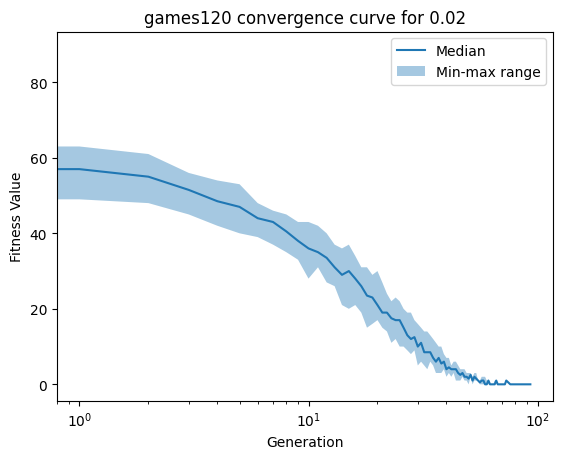

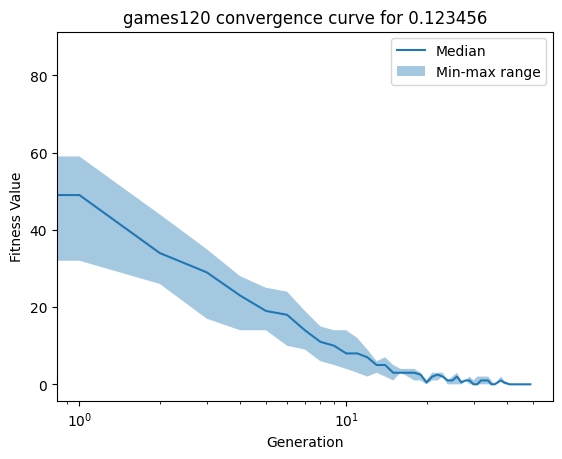

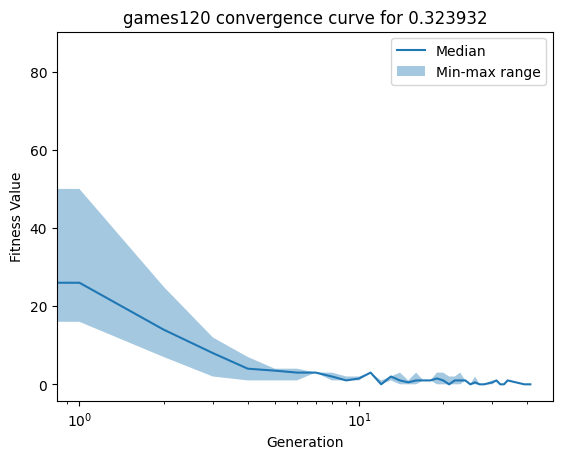

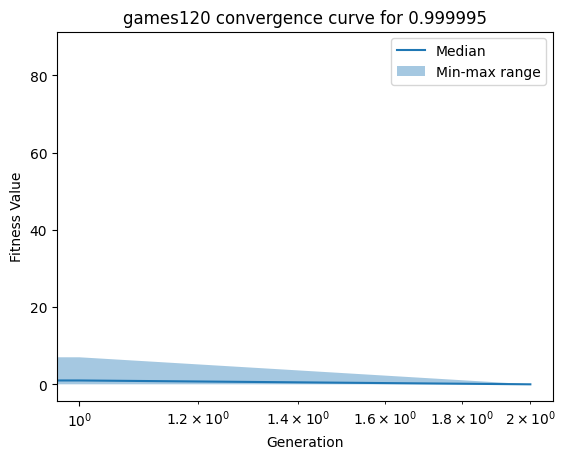

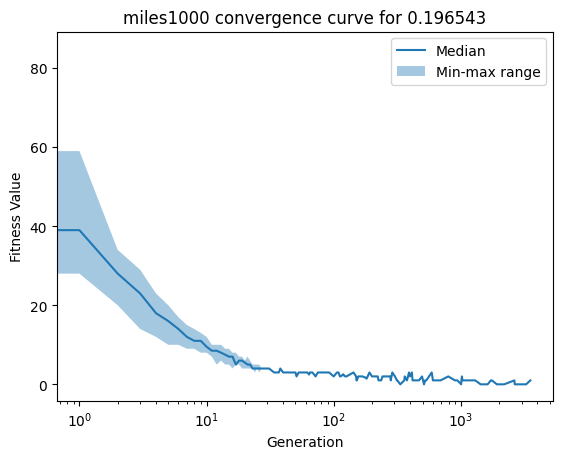

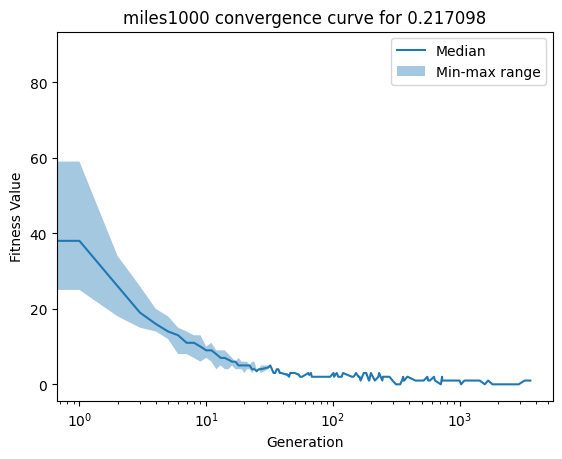

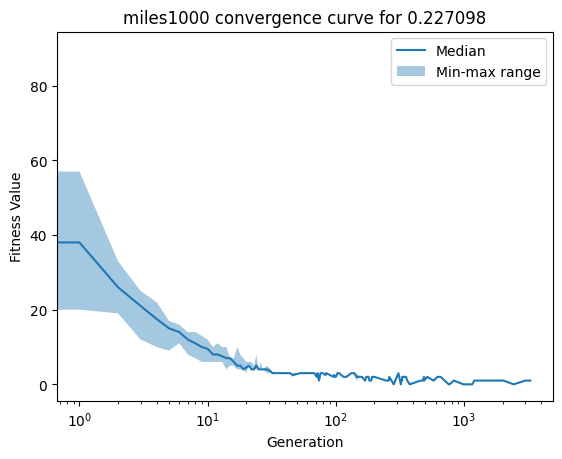

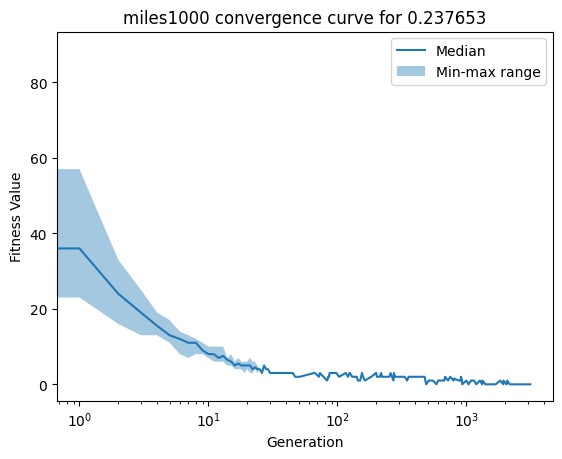

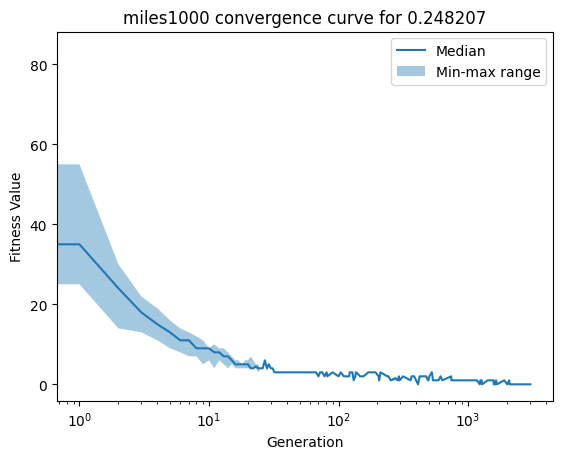

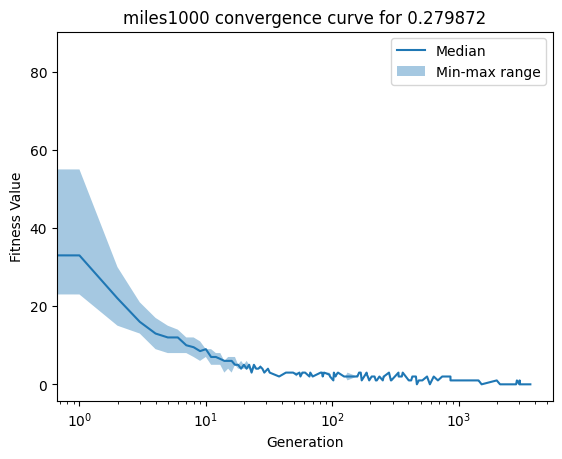

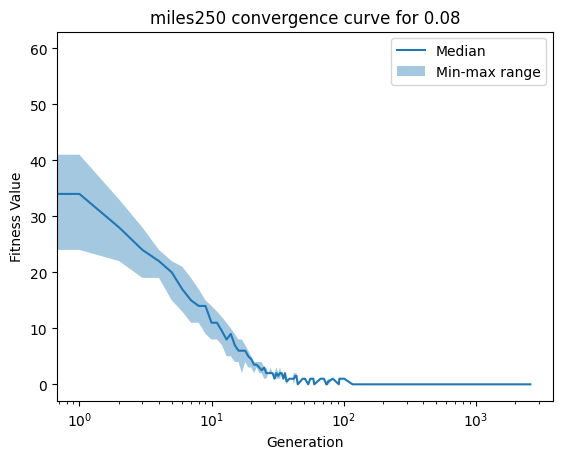

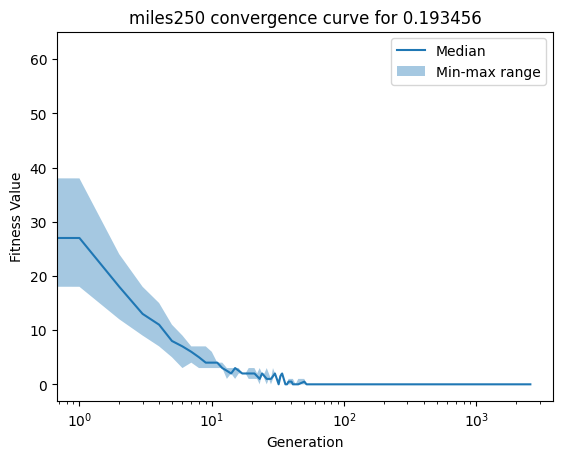

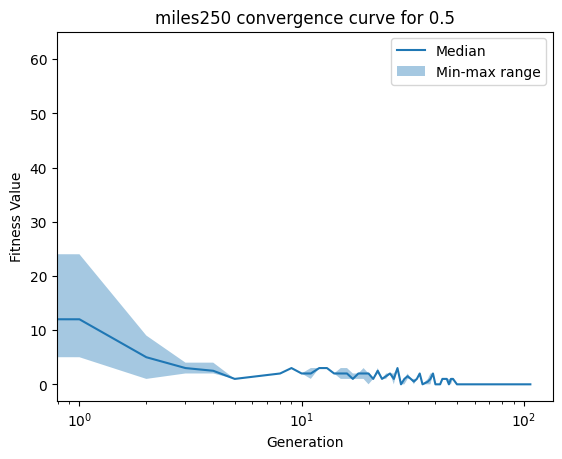

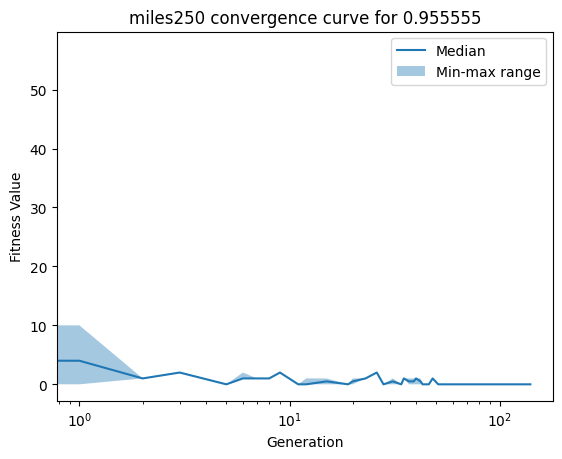

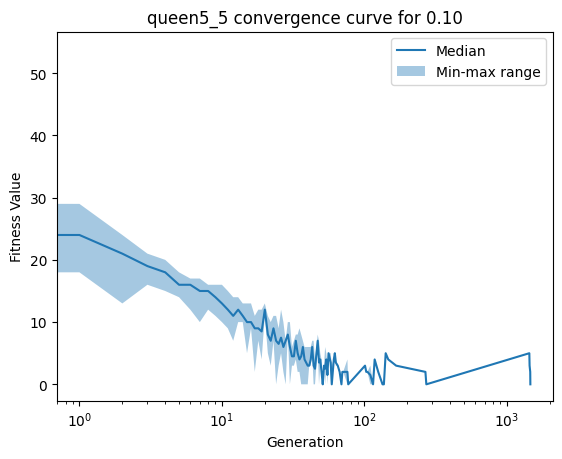

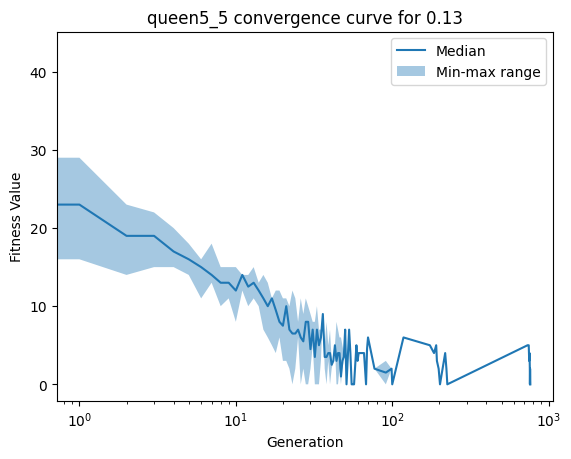

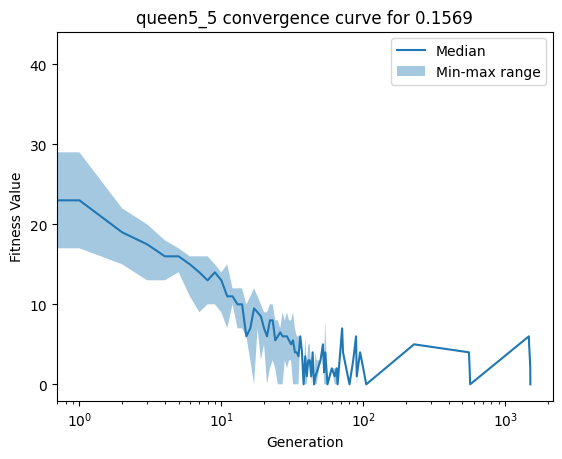

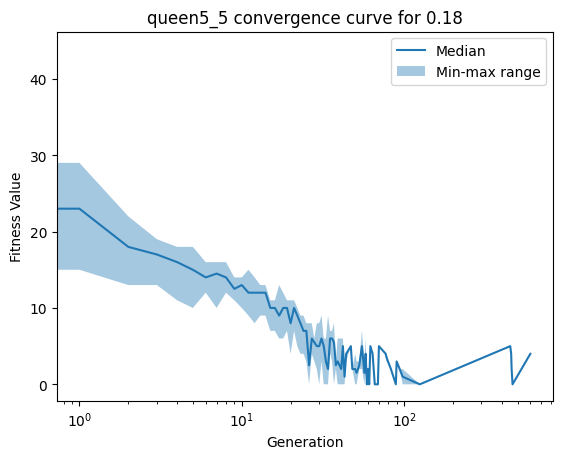

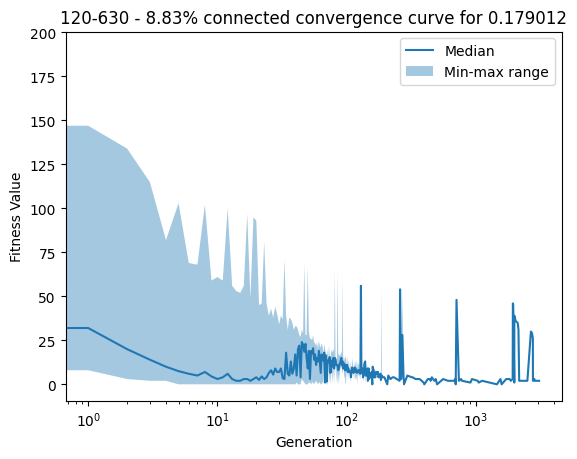

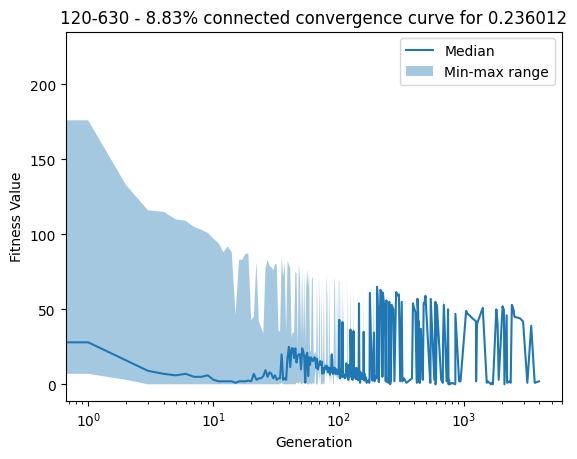

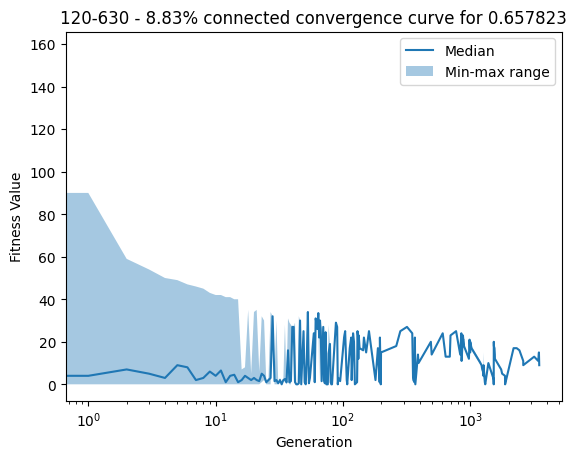

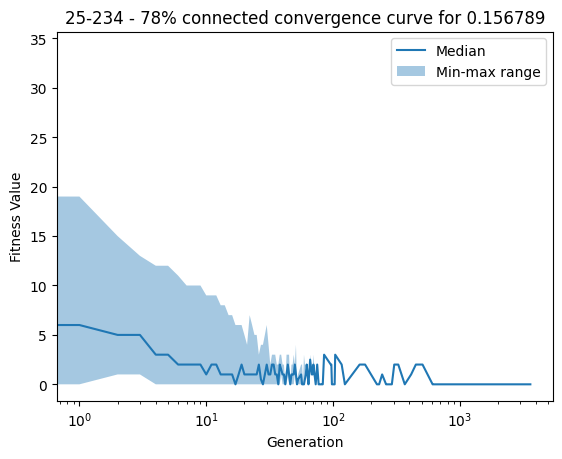

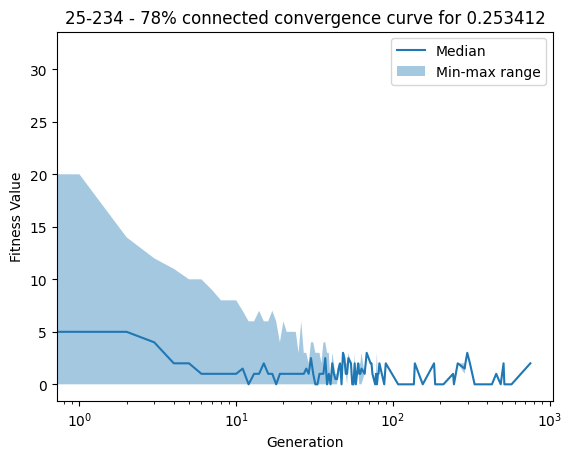

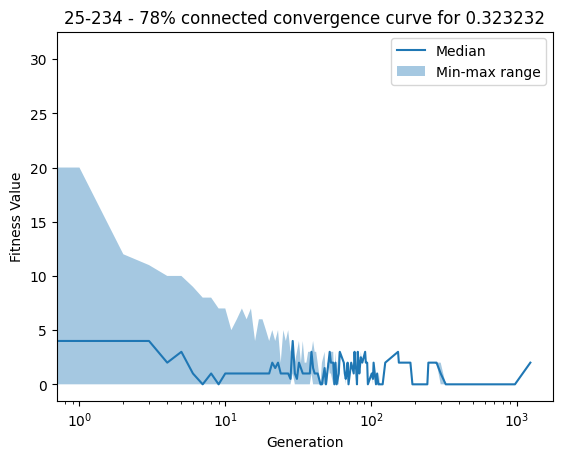

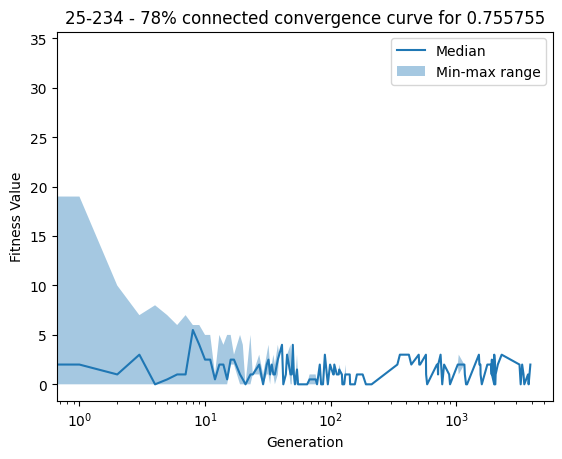

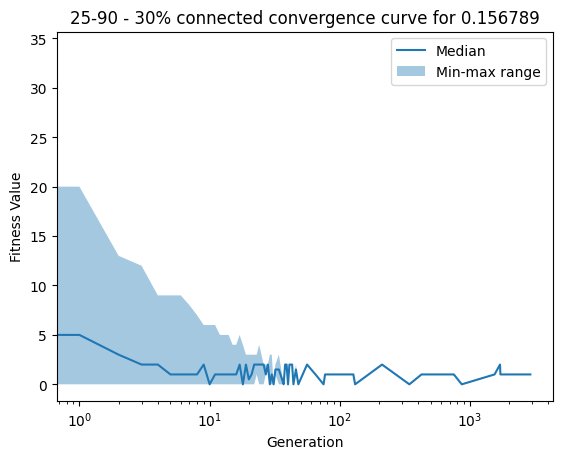

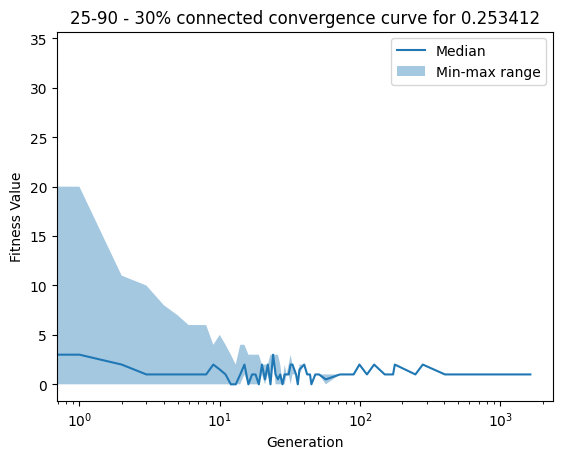

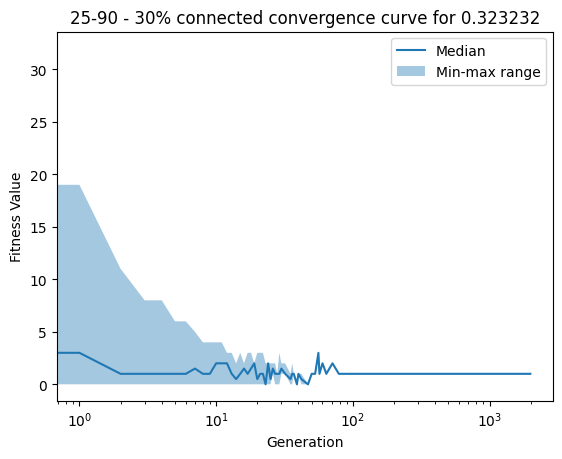

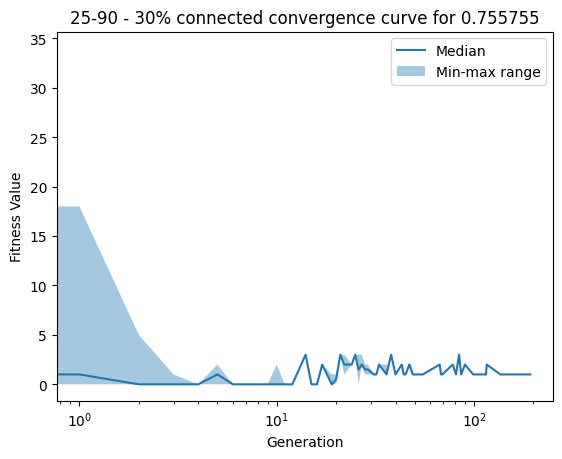

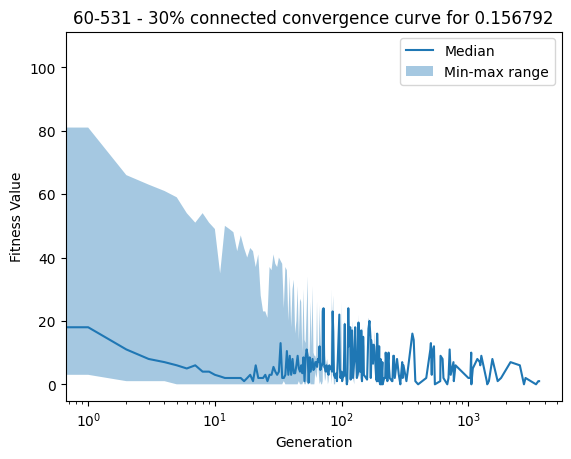

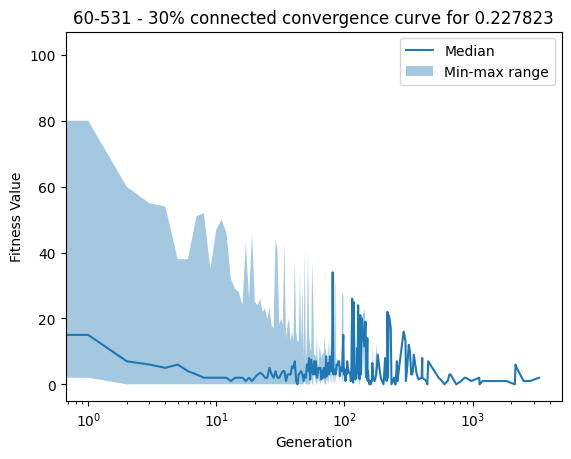

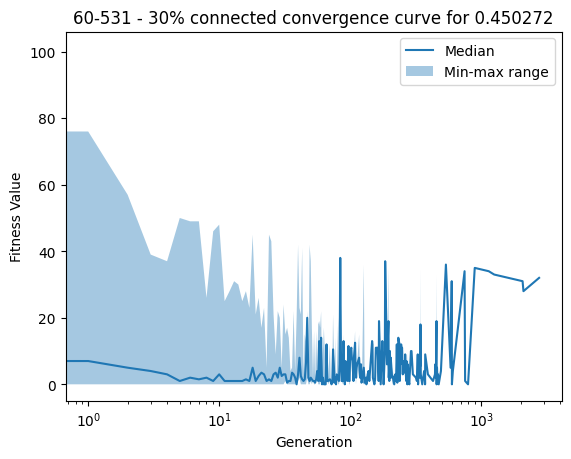

In [15]:
# Plotting converengence curves for each graph
def plot_convergence_curves(results_path):
    graph_folders = [folder for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]

    # Process each graph folder
    for graph_folder in graph_folders:
        graph_path = os.path.join(results_path, graph_folder)
        mut_prob_folders = [folder for folder in os.listdir(graph_path) if os.path.isdir(os.path.join(graph_path, folder))]

        # Process each mutation probability folder
        for mut_prob_folder in mut_prob_folders:
            mut_prob_path = os.path.join(graph_path, mut_prob_folder)
            csv_file = os.path.join(mut_prob_path, 'fitness.csv')

            # Read the CSV file and load data into a list of lists
            with open(csv_file, newline='') as csvfile:
                reader = csv.reader(csvfile)
                data = [row for row in reader]

            # Split the data into runs
            runs = []
            current_run = []
            prev_gen = None
            del data[0] # Skip the header line
            for row in data:
                gen = int(row[0])
                if gen == 0 and prev_gen is not None and prev_gen > 0:
                    runs.append(current_run)
                    current_run = []
                current_run.append(row)
                prev_gen = gen
            if len(current_run) > 0:
                runs.append(current_run)

            # Extract fitness values and generation numbers from the runs
            fitness_values = []
            generation_numbers = []
            chromatic_numbers = []
            for r in runs:
                for row in r:
                    chromatic_numbers.append(int(row[2]))
                    fitness_values.append(int(row[1]))
                    generation_numbers.append(int(row[0]))
            # Convert the data to NumPy arrays
            fitness_values = np.array(fitness_values)
            generation_numbers = np.array(generation_numbers)

            # Compute the median, maximum, and minimum values for each generation across runs
            median_values = []
            max_values = []
            min_values = []
            for gen in np.unique(generation_numbers):
                mask = (generation_numbers == gen)
                median_values.append(np.median(fitness_values[mask]))
                max_values.append(np.max(fitness_values[mask]))
                min_values.append(np.min(fitness_values[mask]))

            # Plot the convergence curve with fill between maximum and minimum values
            plt.plot(np.unique(generation_numbers), median_values, label='Median')
            plt.fill_between(np.unique(generation_numbers), min_values, max_values, alpha=0.4, label='Min-max range')
            plt.xlabel('Generation')
            plt.ylabel('Fitness Value')
            plt.xscale('log')
            plt.title(graph_folder + ' convergence curve for ' + mut_prob_folder)
            plt.legend()

            if not os.path.exists('convergence_curve_graphs'):
                os.makedirs('convergence_curve_graphs')
            if not os.path.exists(os.path.join('convergence_curve_graphs/' + graph_folder)):
                os.makedirs(os.path.join('convergence_curve_graphs/' + graph_folder))

            plt.savefig(os.path.join('convergence_curve_graphs/' + graph_folder, graph_folder + '-' + mut_prob_folder +'.png'))
            plt.show()

plot_convergence_curves('results_EVO')
plot_convergence_curves('results_BIN')